## Transformer 구현 과정 (1/2)
![](https://raw.githubusercontent.com/paul-hyun/paul-hyun.github.io/master/assets/2019-12-19/transformer-model-architecture.png)

Transformer 모델 구현에 대한 설명 입니다.

이 내용을 확인하기 전 아래 내용을 확인하시기 바랍니다.
- [Sentencepiece를 활용해 Vocab 만들기](https://paul-hyun.github.io/vocab-with-sentencepiece/)
- [Naver 영화리뷰 감정분석 데이터 전처리 하기](https://paul-hyun.github.io/preprocess-nsmc/)

[Colab](https://colab.research.google.com/)에서 실행 했습니다.

#### 0. Pip Install
필요한 패키지를 pip를 이용해서 설치합니다.

In [1]:
!pip install sentencepiece

  Using cached sentencepiece-0.1.96.tar.gz (508 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for sentencepiece: filename=sentencepiece-0.1.96-cp38-cp38-macosx_11_0_arm64.whl size=1102731 sha256=3710e9f46181cc73517dbfcc8cff334f3638a1353d76a08b364f3b91290ef7a4
  Stored in directory: /Users/byungwook/Library/Caches/pip/wheels/94/fa/74/bdda662084a3f55d82c80c11c83265199254001a9f0b6bf164
Successfully built sentencepiece


#### 1. Google Drive Mount
Colab에서는 컴퓨터에 자원에 접근이 불가능 하므로 Google Drive에 파일을 올려 놓은 후 Google Drive를 mount 에서 로컬 디스크처럼 사용 합니다.
1. 아래 블럭을 실행하면 나타나는 링크를 클릭하세요.
2. Google 계정을 선택 하시고 허용을 누르면 나타나는 코드를 복사하여 아래 박스에 입력한 후 Enter 키를 입력하면 됩니다.

학습관련 [데이터 및 결과 파일](https://drive.google.com/open?id=15XGr-L-W6DSoR5TbniPMJASPsA0IDTiN)을 참고 하세요.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# data를 저장할 폴더 입니다. 환경에 맞게 수정 하세요.
data_dir = "/content/drive/My Drive/Data/transformer-evolution"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### 2. Imports

In [1]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import sentencepiece as spm

import torch
import torch.nn as nn
import torch.nn.functional as F

#### 3. 폴더의 목록을 확인
Google Drive mount가 잘 되었는지 확인하기 위해 data_dir 목록을 확인 합니다.

In [ ]:
for f in os.listdir(data_dir):
  print(f)

kowiki.csv.gz
kowiki.model
kowiki.vocab
ratings_train.txt
ratings_test.txt
ratings_train.json
ratings_test.json


#### 4. Vocab 및 입력
[Sentencepiece를 활용해 Vocab 만들기](https://paul-hyun.github.io/vocab-with-sentencepiece/)를 통해 만들어 놓은 vocab을 로딩 합니다.

로딩된 vocab을 이용해 input을 만듭니다.

In [3]:
# vocab loading
# get current file path
vocab_file = "/Users/byungwook/Codes/vscode/transformer-evolution/_data/kowiki/kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

# 입력 texts
lines = [
  "겨울은 추워요.",
  "감기 조심하세요."
]

# text를 tensor로 변환
inputs = []
for line in lines:
  pieces = vocab.encode_as_pieces(line)
  ids = vocab.encode_as_ids(line)
  inputs.append(torch.tensor(ids))
  print(pieces)

# 입력 길이가 다르므로 입력 최대 길이에 맟춰 padding(0)을 추가 해 줌
inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
# shape
print(inputs.size())
# 값
print(inputs)

['▁겨울', '은', '▁추', '워', '요', '.']
['▁감', '기', '▁조', '심', '하', '세', '요', '.']
torch.Size([2, 8])
tensor([[3205, 3577,  196, 3929, 3733, 3563,    0,    0],
        [ 201, 3579,   53, 3806, 3569, 3656, 3733, 3563]])


#### 5. Embedding

###### - Input Embedding

In [4]:
n_vocab = len(vocab) # vocab count
d_hidn = 128 # hidden size
nn_emb = nn.Embedding(n_vocab, d_hidn) # embedding 객체

input_embs = nn_emb(inputs) # input embedding
print(input_embs.size())

torch.Size([2, 8, 128])


###### - Position Embedding

In [5]:
""" sinusoid position embedding """
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    return sinusoid_table

(64, 128)


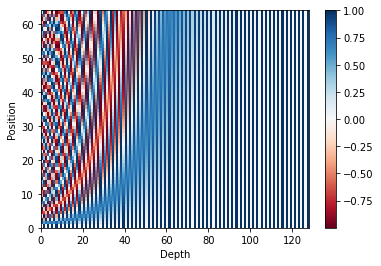

In [6]:
n_seq = 64
pos_encoding = get_sinusoid_encoding_table(n_seq, d_hidn)

print (pos_encoding.shape) # 크기 출력
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d_hidn))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [7]:
pos_encoding = torch.FloatTensor(pos_encoding)
nn_pos = nn.Embedding.from_pretrained(pos_encoding, freeze=True)

positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
pos_mask = inputs.eq(0)

positions.masked_fill_(pos_mask, 0)
pos_embs = nn_pos(positions) # position embedding

print(inputs)
print(positions)
print(pos_embs.size())

tensor([[3205, 3577,  196, 3929, 3733, 3563,    0,    0],
        [ 201, 3579,   53, 3806, 3569, 3656, 3733, 3563]])
tensor([[1, 2, 3, 4, 5, 6, 0, 0],
        [1, 2, 3, 4, 5, 6, 7, 8]])
torch.Size([2, 8, 128])


In [8]:
input_sums = input_embs + pos_embs

#### 6. Scale Dot Product Attention

![](https://raw.githubusercontent.com/paul-hyun/paul-hyun.github.io/master/assets/2019-12-19/scale_dot_product_attention.png)

###### Input

In [22]:
Q = input_sums
K = input_sums
V = input_sums
print(K.size(2))
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_mask.size())
print(attn_mask[0])

128
torch.Size([2, 8, 8])
tensor([[False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True]])


In [14]:
print(inputs.eq(0).unsqueeze(1))

tensor([[[False, False, False, False, False, False,  True,  True]],

        [[False, False, False, False, False, False, False, False]]])


##### Q * K-transpose

In [26]:
scores = torch.matmul(Q, K.transpose(-1, -2))
print(scores.size())
print(scores[0])

torch.Size([2, 8, 8])
tensor([[216.1249,  70.5508,  55.5360,  56.6154,  73.0909,  61.5681,  66.8608,
          66.8608],
        [ 70.5508, 174.1238,  61.9568,  64.1468,  63.3292,  57.4110,  44.0897,
          44.0897],
        [ 55.5360,  61.9568, 163.1032,  61.9124,  79.4910,  43.9295,  32.0808,
          32.0808],
        [ 56.6154,  64.1468,  61.9124, 207.3697,  76.9481,  78.8776,  48.7467,
          48.7467],
        [ 73.0909,  63.3292,  79.4910,  76.9481, 187.2302, 110.2944,  59.7992,
          59.7992],
        [ 61.5681,  57.4110,  43.9295,  78.8776, 110.2944, 217.4121,  56.4605,
          56.4605],
        [ 66.8608,  44.0897,  32.0808,  48.7467,  59.7992,  56.4605, 176.0454,
         176.0454],
        [ 66.8608,  44.0897,  32.0808,  48.7467,  59.7992,  56.4605, 176.0454,
         176.0454]], grad_fn=<SelectBackward>)


###### Scale

In [ ]:
d_head = 64
scores = scores.mul_(1/d_head**0.5)
print(scores.size())
print(scores[0])

torch.Size([2, 8, 8])
tensor([[31.3476, -0.1451, -1.4832, -2.8843, -1.2542,  0.8314, -5.7174, -5.7174],
        [-0.1451, 27.8460,  4.9304,  0.8781,  1.5047,  1.6372,  0.5585,  0.5585],
        [-1.4832,  4.9304, 26.8313,  3.9618,  2.1587,  3.5587,  3.0447,  3.0447],
        [-2.8843,  0.8781,  3.9618, 27.9037,  1.6892,  4.0453,  4.7429,  4.7429],
        [-1.2542,  1.5047,  2.1587,  1.6892, 32.0763,  4.0136, -1.1263, -1.1263],
        [ 0.8314,  1.6372,  3.5587,  4.0453,  4.0136, 38.0982, -2.7216, -2.7216],
        [-5.7174,  0.5585,  3.0447,  4.7429, -1.1263, -2.7216, 56.9788, 56.9788],
        [-5.7174,  0.5585,  3.0447,  4.7429, -1.1263, -2.7216, 56.9788, 56.9788]],
       grad_fn=<SelectBackward>)


###### Mask (Opt.)

In [ ]:
scores.masked_fill_(attn_mask, -1e9)
print(scores.size())
print(scores[0])

torch.Size([2, 8, 8])
tensor([[ 3.1348e+01, -1.4505e-01, -1.4832e+00, -2.8843e+00, -1.2542e+00,
          8.3138e-01, -1.0000e+09, -1.0000e+09],
        [-1.4505e-01,  2.7846e+01,  4.9304e+00,  8.7807e-01,  1.5047e+00,
          1.6372e+00, -1.0000e+09, -1.0000e+09],
        [-1.4832e+00,  4.9304e+00,  2.6831e+01,  3.9618e+00,  2.1587e+00,
          3.5587e+00, -1.0000e+09, -1.0000e+09],
        [-2.8843e+00,  8.7807e-01,  3.9618e+00,  2.7904e+01,  1.6892e+00,
          4.0453e+00, -1.0000e+09, -1.0000e+09],
        [-1.2542e+00,  1.5047e+00,  2.1587e+00,  1.6892e+00,  3.2076e+01,
          4.0136e+00, -1.0000e+09, -1.0000e+09],
        [ 8.3138e-01,  1.6372e+00,  3.5587e+00,  4.0453e+00,  4.0136e+00,
          3.8098e+01, -1.0000e+09, -1.0000e+09],
        [-5.7174e+00,  5.5846e-01,  3.0447e+00,  4.7429e+00, -1.1263e+00,
         -2.7216e+00, -1.0000e+09, -1.0000e+09],
        [-5.7174e+00,  5.5846e-01,  3.0447e+00,  4.7429e+00, -1.1263e+00,
         -2.7216e+00, -1.0000e+09, -1.0000e

###### Softmax

In [ ]:
attn_prob = nn.Softmax(dim=-1)(scores)
print(attn_prob.size())
print(attn_prob[0])

torch.Size([2, 8, 8])
tensor([[1.0000e+00, 2.1033e-14, 5.5176e-15, 1.3591e-15, 6.9378e-15, 5.5841e-14,
         0.0000e+00, 0.0000e+00],
        [6.9763e-13, 1.0000e+00, 1.1165e-10, 1.9407e-12, 3.6318e-12, 4.1463e-12,
         0.0000e+00, 0.0000e+00],
        [5.0487e-13, 3.0802e-10, 1.0000e+00, 1.1693e-10, 1.9268e-11, 7.8133e-11,
         0.0000e+00, 0.0000e+00],
        [4.2551e-14, 1.8319e-12, 4.0010e-11, 1.0000e+00, 4.1224e-12, 4.3491e-11,
         0.0000e+00, 0.0000e+00],
        [3.3480e-15, 5.2839e-14, 1.0162e-13, 6.3540e-14, 1.0000e+00, 6.4945e-13,
         0.0000e+00, 0.0000e+00],
        [6.5344e-17, 1.4628e-16, 9.9921e-16, 1.6255e-15, 1.5748e-15, 1.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.3843e-05, 1.2675e-02, 1.5230e-01, 8.3218e-01, 2.3510e-03, 4.7689e-04,
         0.0000e+00, 0.0000e+00],
        [2.3843e-05, 1.2675e-02, 1.5230e-01, 8.3218e-01, 2.3510e-03, 4.7689e-04,
         0.0000e+00, 0.0000e+00]], grad_fn=<SelectBackward>)


###### atten_prov * V

In [ ]:
context = torch.matmul(attn_prob, V)
print(context.size())

torch.Size([2, 8, 128])


###### Implementation Class

In [ ]:
""" scale dot product attention """
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_head):
        super().__init__()
        self.scale = 1 / (d_head ** 0.5)
    
    def forward(self, Q, K, V, attn_mask):
        # (bs, n_head, n_q_seq, n_k_seq)
        scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        # (bs, n_head, n_q_seq, n_k_seq)
        attn_prob = nn.Softmax(dim=-1)(scores)
        # (bs, n_head, n_q_seq, d_v)
        context = torch.matmul(attn_prob, V)
        # (bs, n_head, n_q_seq, d_v), (bs, n_head, n_q_seq, n_v_seq)
        return context, attn_prob

#### 7. Multi-Head Attention

![](https://raw.githubusercontent.com/paul-hyun/paul-hyun.github.io/master/assets/2019-12-19/multi_head_attention.png)

###### Input

In [ ]:
Q = input_sums
K = input_sums
V = input_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))

batch_size = Q.size(0)
n_head = 2

###### Multi Head Q, K, V

In [ ]:
W_Q = nn.Linear(d_hidn, n_head * d_head)
W_K = nn.Linear(d_hidn, n_head * d_head)
W_V = nn.Linear(d_hidn, n_head * d_head)

# (bs, n_seq, n_head * d_head)
q_s = W_Q(Q)
print(q_s.size())
# (bs, n_seq, n_head, d_head)
q_s = q_s.view(batch_size, -1, n_head, d_head)
print(q_s.size())
# (bs, n_head, n_seq, d_head)
q_s = q_s.transpose(1,2)
print(q_s.size())

torch.Size([2, 8, 128])
torch.Size([2, 8, 2, 64])
torch.Size([2, 2, 8, 64])


In [ ]:
# (bs, n_head, n_seq, d_head)
q_s = W_Q(Q).view(batch_size, -1, n_head, d_head).transpose(1,2)
# (bs, n_head, n_seq, d_head)
k_s = W_K(K).view(batch_size, -1, n_head, d_head).transpose(1,2)
# (bs, n_head, n_seq, d_head)
v_s = W_V(V).view(batch_size, -1, n_head, d_head).transpose(1,2)
print(q_s.size(), k_s.size(), v_s.size())

torch.Size([2, 2, 8, 64]) torch.Size([2, 2, 8, 64]) torch.Size([2, 2, 8, 64])


###### Multi Head Attention Mask

In [ ]:
print(attn_mask.size())
attn_mask = attn_mask.unsqueeze(1).repeat(1, n_head, 1, 1)
print(attn_mask.size())

torch.Size([2, 8, 8])
torch.Size([2, 2, 8, 8])


###### Attention

In [ ]:
scaled_dot_attn = ScaledDotProductAttention(d_head)
context, attn_prob = scaled_dot_attn(q_s, k_s, v_s, attn_mask)
print(context.size())
print(attn_prob.size())

torch.Size([2, 2, 8, 64])
torch.Size([2, 2, 8, 8])


###### Concat

In [ ]:
# (bs, n_seq, n_head * d_head)
context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_head * d_head)
print(context.size())

torch.Size([2, 8, 128])


###### Linear

In [ ]:
linear = nn.Linear(n_head * d_head, d_hidn)
# (bs, n_seq, d_hidn)
output = linear(context)
print(output.size())

torch.Size([2, 8, 128])


###### Implementation Class

In [ ]:
""" multi head attention """
class MultiHeadAttention(nn.Module):
    def __init__(self, d_hidn, n_head, d_head):
        super().__init__()
        self.d_hidn = d_hidn
        self.n_head = n_head
        self.d_head = d_head

        self.W_Q = nn.Linear(d_hidn, n_head * d_head)
        self.W_K = nn.Linear(d_hidn, n_head * d_head)
        self.W_V = nn.Linear(d_hidn, n_head * d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(d_head)
        self.linear = nn.Linear(n_head * d_head, d_hidn)
    
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)

        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_head, 1, 1)

        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_head * self.d_head)
        # (bs, n_head, n_q_seq, e_embd)
        output = self.linear(context)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob

#### 8. Masked Multi Head Attention

In [ ]:
""" attention decoder mask """
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1) # upper triangular part of a matrix(2-D)
    return subsequent_mask


Q = input_sums
K = input_sums
V = input_sums

attn_pad_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_pad_mask[0])
attn_dec_mask = get_attn_decoder_mask(inputs)
print(attn_dec_mask[0])
attn_mask = torch.gt((attn_pad_mask + attn_dec_mask), 0)
print(attn_mask[0])

batch_size = Q.size(0)
n_head = 2

tensor([[False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True]])
tensor([[0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[False,  True,  True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True,  True,  True],


In [ ]:
attention = MultiHeadAttention(d_hidn, n_head, d_head)
output, attn_prob = attention(Q, K, V, attn_mask)
print(output.size(), attn_prob.size())

torch.Size([2, 8, 128]) torch.Size([2, 2, 8, 8])


#### 9. Feed Forward

![](https://raw.githubusercontent.com/paul-hyun/paul-hyun.github.io/master/assets/2019-12-19/feed-forward.png)

###### f1 (Liear)

In [ ]:
conv1 = nn.Conv1d(in_channels=d_hidn, out_channels=d_hidn * 4, kernel_size=1)
# (bs, d_hidn * 4, n_seq)
ff_1 = conv1(output.transpose(1, 2))
print(ff_1.size())

torch.Size([2, 512, 8])


###### Activation (relu or gelu)

![](https://raw.githubusercontent.com/paul-hyun/paul-hyun.github.io/master/assets/2019-12-19/activation.png)

In [ ]:
# active = F.relu
active = F.gelu
ff_2 = active(ff_1)

###### f3 (Liear)

In [ ]:
conv2 = nn.Conv1d(in_channels=d_hidn * 4, out_channels=d_hidn, kernel_size=1)
ff_3 = conv2(ff_2).transpose(1, 2)
print(ff_3.size())

torch.Size([2, 8, 128])


###### Implementation Class

In [ ]:
""" feed forward """
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_hidn):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_hidn * 4, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_hidn * 4, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu

    def forward(self, inputs):
        # (bs, d_ff, n_seq)
        output = self.active(self.conv1(inputs.transpose(1, 2)))
        # (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1, 2)
        # (bs, n_seq, d_hidn)
        return output